In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import skimage.io as io
import skimage.transform as trans
import shutil

from skimage import data
from skimage.io import imread, imshow

In [6]:
def create_dir_tree(directory, names):
    '''
    Crea directorio con n muestras,
    '''
    if os.path.exists(directory):
        shutil.rmtree(directory) # borramos directorio y lurgo le creamos
        
    os.mkdir(directory)
        
    for name in names:
        sample = os.path.join(directory,name)
        os.mkdir(sample)

In [7]:
random_names = pd.read_csv('random_names.csv')
random_names = random_names['Names'][:len(os.listdir("CASIA-IrisV1"))]
new_dir = "CASIA-Iris"
create_dir_tree(new_dir,random_names)

In [8]:
def copy_samples(to_dir, from_dir):
    directories = os.listdir(to_dir) # nombres de las muestras
    i = 0
    k = 1
    for root, dirs, files in os.walk(from_dir):
        for file in files:
            if file.endswith(".bmp"):
                source = os.path.join(root, file)
                dest = os.path.join(to_dir,directories[i])
                shutil.copy(source, dest)
                if len(os.listdir(dest)) == 7:
                    i = i + 1
                    continue

In [9]:
copy_samples(new_dir, "CASIA-IrisV1")

In [10]:
# cambiamos nombre a las muestras
for root, dirs, files in os.walk(new_dir):
    for d in dirs:
        name = str(d)
        k = 1
        for i in os.listdir(os.path.join(new_dir,d)):
            os.rename(os.path.join(os.path.join(new_dir,d),i), os.path.join(os.path.join(new_dir,d),name + '_' + str(k)+'.bmp'))
            k += 1

In [11]:
def get_paths(directory):
    '''
    Devuelve la ruta relativa de las muestras .bmp
    '''
    paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".bmp"):
                paths.append(os.path.join(root, file))
    return paths

In [12]:
paths_casia = get_paths("CASIA-Iris")
original_samples = [cv2.imread(muestra,0) for muestra in paths_casia] # array de las muestras originales en b&w

In [13]:
paths_casia[:10]

['CASIA-Iris\\Adrianna\\Adrianna_1.bmp',
 'CASIA-Iris\\Adrianna\\Adrianna_2.bmp',
 'CASIA-Iris\\Adrianna\\Adrianna_3.bmp',
 'CASIA-Iris\\Adrianna\\Adrianna_4.bmp',
 'CASIA-Iris\\Adrianna\\Adrianna_5.bmp',
 'CASIA-Iris\\Adrianna\\Adrianna_6.bmp',
 'CASIA-Iris\\Adrianna\\Adrianna_7.bmp',
 'CASIA-Iris\\Aharon\\Aharon_1.bmp',
 'CASIA-Iris\\Aharon\\Aharon_2.bmp',
 'CASIA-Iris\\Aharon\\Aharon_3.bmp']

In [14]:
def testGenerator(images, target_size= (320,320)):
    for muestra in images:
        img = muestra / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [15]:
def saveResult(results, save_dir, names):
    '''
    Guarda los imágenes segmentadas resultado de la red preentrenada
    
    Parámetros:
    results -- resultado de la red preentrenada
    save_path -- ruta en la que se guardarán las muestras segmentadas
    name_path -- directorio del que cogeremos los nombres de las muestras
    '''
    dim = (320, 280) # dimensiones originales de las muestras del dataset
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)
        
    os.mkdir(save_dir)
    for i,item in enumerate(results):
        img = item[:,:,0]
        img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        io.imsave(os.path.join(save_dir,names[i]),img)

In [16]:
from keras.models import load_model

model = load_model('Iris_unet_d5.h5')
# model.summary()

Using TensorFlow backend.


In [17]:
gen = testGenerator(original_samples)
results = model.predict(gen,verbose=1)

756/756 [==============================] - 1004s 1s/step


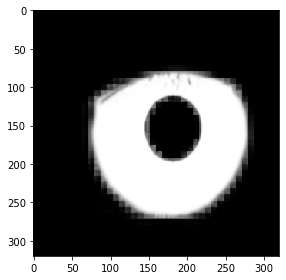

In [18]:
imshow(results[0][:,:,0]);

In [19]:
# guardamos la salida de la red en una nueva lista para que sea accesible
unet_outputs = []
dim = (320, 280) # dimensiones originales de las muestras del dataset
for r in results:
    img = r[:,:,0]
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    unet_outputs.append(img)

In [35]:
# reescalamos outputs a 0-1
unet_outputs = [cv2.normalize(src=img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) 
                for img in unet_outputs]

### Aplicamos los operadores morfológicos

In [38]:
def morph_operator(images):
    enhanced = []
    for img in images:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        (thresh, binRed) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY) # se binariza
        opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2) # se aplica operadores morfológicos(vigilar iteraciones)
        (thresh, binRed) = cv2.threshold(opening, 128, 255, cv2.THRESH_BINARY) # se binariza nuevamente

        enhanced.append(binRed)
    return enhanced

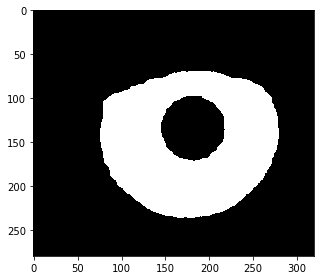

In [41]:
enhanced_outputs = morph_operator(unet_outputs)
imshow(enhanced_outputs[0]);

In [42]:
def canny_edges(images):
    canny_edges = []
    for img in images:
        edges = cv2.Canny(img, 10, 255)
        canny_edges.append(edges)
    
    return canny_edges

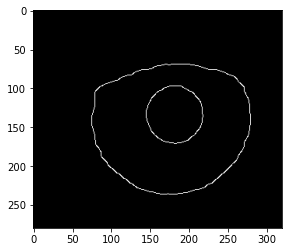

In [50]:
edged_outputs = canny_edges(enhanced_outputs)
plt.imshow(edged_outputs[0],"gray");

In [55]:
from skimage import data
from skimage.transform import (hough_line, hough_line_peaks, hough_circle, hough_circle_peaks)
from skimage.draw import circle_perimeter
from skimage.color import gray2rgb
from matplotlib import cm
from time import time

In [56]:
def draw_circles(img, cx, cy, radii):
    '''
    A partir de los centros y el radio detectados dibuja el iris sobre la imagen que se le
    pasa como parámetro.
    '''
    image = img
    pupil = cv2.circle(image,(cx[0],cy[0]), radii[0], (255, 0, 0), 2)
    iris = cv2.circle(image,(cx[1],cy[1]), radii[1], (255, 0, 0), 2)
    return image

In [59]:
# EJECUTAR UNA VEZ QUE TARDA MUCHO!!!
def get_centers_radius(canny_images, original_images):
    boundaries = [] # contiene los bordes límbico y pupilar
    centers = [] # contiene centros y radio de la pupila
    i = 0
    tiempo_inicial = time()
    
    for img in canny_images:
        gray_img= img
        hough_radii = np.arange(20, 150, 2) # ajustar manualmente para que empiece desde un rango que incluya tanto al iris como a la pupila
        hough_res = hough_circle(gray_img, hough_radii)
        accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=2) # total_num_peaks -> nro de círculos
        x_pupil, x_iris = cx
        y_pupil, y_iris = cy
        radius_pupil, radius_iris = radii
        
        # guardamos centros y radios
        boundaries.append(draw_circles(original_images[i], cx, cy, radii))
        data = {'pupil':[x_pupil, y_pupil, radius_pupil],
                'iris':[x_iris, y_iris, radius_iris]}
        centers.append(data)
        i = i+1
    tiempo_final = time()
    
    print(f'DONE!, time elapsed:{tiempo_final-tiempo_inicial}')
    
    return boundaries, centers


In [60]:
boundaries, centers = get_centers_radius(edged_outputs, original_samples)

DONE!, time elapsed:325.8369765281677


In [61]:
boundaries[0]

array([[176, 166, 170, ..., 187, 180, 169],
       [170, 169, 173, ..., 185, 181, 179],
       [177, 165, 173, ..., 198, 187, 169],
       ...,
       [154, 155, 155, ..., 169, 178, 199],
       [159, 148, 154, ..., 170, 177, 192],
       [153, 154, 150, ..., 172, 171, 189]], dtype=uint8)

In [69]:
centers[0]

{'pupil': [182, 134, 36], 'iris': [177, 134, 102]}

### Normalización

In [76]:
pupil_centers = [center['pupil'] for center in centers]
pupil_centers[:10]

[[182, 134, 36],
 [174, 138, 38],
 [173, 120, 38],
 [183, 122, 40],
 [177, 145, 38],
 [178, 134, 38],
 [154, 131, 36],
 [181, 140, 50],
 [183, 139, 48],
 [172, 157, 46]]

In [80]:
def iris_normalization(boundaries,centers):
    normalized = []
    cent=0
    for img in boundaries:
#         img = normalized[name]
        #load pupil centers and radius of inner circles
        center_x = centers[cent][0]
        center_y = centers[cent][1]
        radius_pupil=int(centers[cent][2])
        
        iris_radius = 53 # width of space between inner and outer boundary
    
        #define equally spaced interval to iterate over
        nsamples = 360
        samples = np.linspace(0,2*np.pi, nsamples)[:-1]
        polar = np.zeros((iris_radius, nsamples))
        for r in range(iris_radius):
            for theta in samples:
                #get x and y for values on inner boundary
                x = (r+radius_pupil)*np.cos(theta)+center_x
                y = (r+radius_pupil)*np.sin(theta)+center_y
                x=int(x)
                y=int(y)
                try:
                #convert coordinates
                    polar[r][int((theta*nsamples)/(2*np.pi))] = img[y][x]
                except IndexError: #ignores values which lie out of bounds
                    pass
                continue
        res = cv2.resize(polar,(512,64))
        normalized.append(res)
        cent+=1
    print('DONE!')
    return normalized #returns a list of 64x512 normalized images

In [81]:
normalized_outputs = iris_normalization(boundaries,pupil_centers)

DONE!


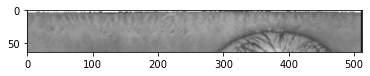

In [83]:
plt.imshow(normalized_outputs[0],"gray");

In [94]:
from skimage import exposure
def crop_and_ecualization(normalized):
    enhanced = []
    for img in normalized:
        h,w = img.shape
        roi = img[5:h, 0:int(512/2)]
        roi_enhanced = exposure.equalize_hist(roi)
        enhanced.append(roi_enhanced)
    print("DONE!")
    
    return enhanced

In [95]:
normalized_outputs = crop_and_ecualization(normalized_outputs)

DONE!


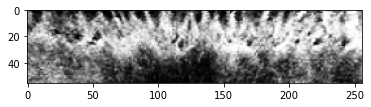

In [96]:
plt.imshow(normalized_outputs[0],"gray");

In [137]:
if os.path.exists(new_dir):
    shutil.rmtree(new_dir)
new_dir = "CASIA-Polar"
create_dir_tree(new_dir,random_names)

In [142]:
names = os.listdir(new_dir)
paths = [os.path.join(new_dir, d) for d in names]
paths[:10]

['CASIA-Polar\\Adrianna',
 'CASIA-Polar\\Aharon',
 'CASIA-Polar\\Aidan',
 'CASIA-Polar\\Aiza',
 'CASIA-Polar\\Aleah',
 'CASIA-Polar\\Alice',
 'CASIA-Polar\\Alvin',
 'CASIA-Polar\\Amayah',
 'CASIA-Polar\\Amberly',
 'CASIA-Polar\\Aminata']

In [139]:
i = 0
k = 1
for file in normalized_outputs:
    dest = paths[i]
    io.imsave(os.path.join(dest,names[i] +'_'+ str(k) + '.bmp'),file)
    if len(os.listdir(dest)) == 7:
        i = i + 1
        k = 1
        continue
    k = k + 1